In [71]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, TimeDistributed, LSTM, LayerNormalization
from keras import regularizers
from keras.models import load_model
from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import lime                                                             
import lime.lime_tabular

In [72]:
def load_dataset(filename):
    df = pd.read_csv(filename)

    # Clean up dataset
    nan_value = float("NaN")

    df.replace("", nan_value, inplace=True)
    df.dropna(inplace=True)
    df['Flag'].replace("R",0, inplace=True)
    df['Flag'].replace("T",1, inplace=True)

    for i in range(3, 11):
        df.iloc[:, i] = df.iloc[:, i].apply(int, base=16)

    df.iloc[:, 1] = df.iloc[:, 1].apply(int, base=16)

    feature_cols = ['ID', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8']

    X = df.loc[:, feature_cols].values
    y = df['Flag'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=feature_cols)
    # X_scaled = np.array(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.20, random_state=5)

    X_train = X_train.astype(float)
    X_train = pd.DataFrame(X_train, columns=['ID', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8'])

    y_train = y_train.astype(float)
    y_train = pd.DataFrame(y_train, columns=['Flag'])

    X_test = X_test.astype(float)
    X_test = pd.DataFrame(X_test, columns=['ID', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8'])

    y_test = y_test.astype(float)
    y_test = pd.DataFrame(y_test, columns=['Flag'])

    return X_train, X_test, y_train, y_test

In [73]:
def ann(self, X_train, y_train, modelname):
    model_ann = Sequential()
    model_ann.add(Dense(16, input_dim=9, activation='relu', kernel_initializer='he_uniform',
                        kernel_regularizer=regularizers.l2(0.0001)))
    model_ann.add(BatchNormalization())
    model_ann.add(Dropout(0.2))
    model_ann.add(
        Dense(16, kernel_initializer='he_uniform', activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model_ann.add(BatchNormalization())
    model_ann.add(Dropout(0.2))
    model_ann.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model_ann.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    model_ann.fit(X_train, y_train, epochs=10, batch_size=128)
    model_ann.save(modelname)
    print("Done Training!")

In [74]:

X_train, X_test, y_train, y_test = load_dataset('dos_cleaned.csv')

model_ann = load_model('simpleann/AJ_dos_model')

y_pred = model_ann.predict(X_test)

y_pred = y_pred.astype(int)

from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Area Under Curve: ", metrics.roc_auc_score(y_test, y_pred))

tp = metrics.confusion_matrix(y_test, y_pred)
print(tp)

t_TN, t_FP, t_FN, t_TP = metrics.confusion_matrix(y_test, y_pred).ravel()
print("True Positive:",t_TP)
print("False Positive:",t_FP)
print("True Negative: ",t_TN)
print("False Negative: ",t_FN)
#fpr = round(self.t_FP / (self.t_FP + self.t_TN), 3)

22912/22912 [==============================] - 25s 1ms/step
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
Area Under Curve:  1.0
[[615489      0]
 [     0 117666]]
True Positive: 117666
False Positive: 0
True Negative:  615489
False Negative:  0


In [75]:
# Creating Lime explainer object
exp = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy() ,
                                             feature_names=X_train.columns,
                                             mode='classification',
                                             training_labels=y_train.to_numpy())

In [76]:
def return_prob(data):
    p1,p2 = (np.ones(len(data))[0] - model_ann.predict(data)),  model_ann.predict(data)
    prediction = [[x,y] for x,y in zip(p1,p2)]
    return np.array(prediction).reshape(len(data),2)

In [84]:
X_test = X_test.join(y_test['Flag'])

test_0 = X_test.loc[X_test['Flag']==0]
test_1 = X_test.loc[X_test['Flag']==1]
_ = test_0.pop('Flag')
_ = test_1.pop('Flag')

negative_lime = exp.explain_instance(test_0.to_numpy()[0],return_prob,top_labels=2)
positive_lime = exp.explain_instance(test_1.to_numpy()[0],return_prob,top_labels=2)

157/157 [==============================] - 0s 1ms/step


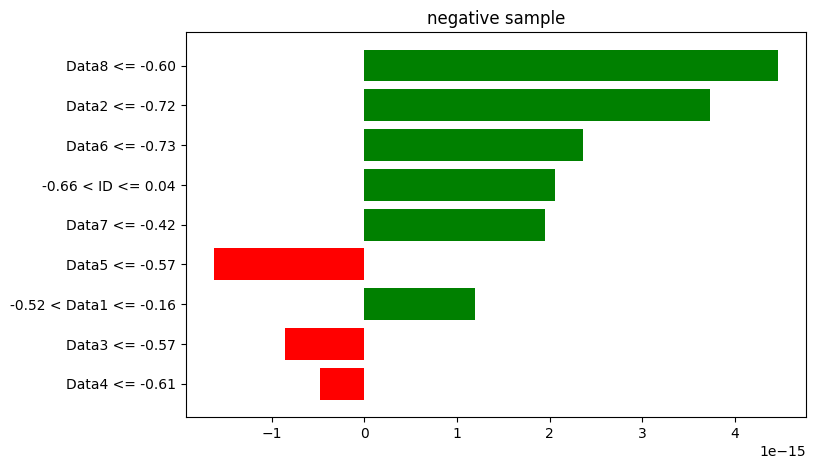

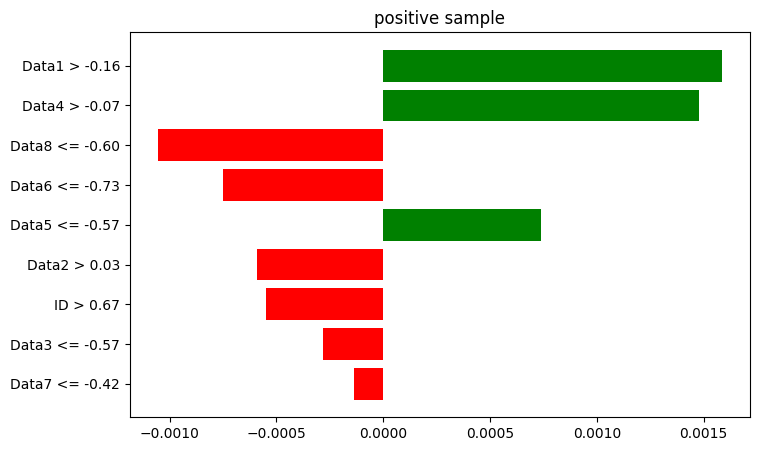

In [85]:
def lime_exp_as_pyplot(exp,flag):
    exp_list = exp.as_list(label=1)
    fig, ax = plt.subplots(figsize=(8,5))
    
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]
    
    vals.reverse()
    names.reverse()
    
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp_list)) + .5
    
    ax.barh(pos, vals, align='center', color=colors)
    
    plt.yticks(pos, names)
    plt.title(flag)
    return fig, ax

f, ax = lime_exp_as_pyplot(negative_lime,'negative sample') 
f, ax = lime_exp_as_pyplot(positive_lime,'positive sample')